## 아파트와 빌라의 매매현황 분석 ##
- 탐색적 데이터 분석

In [79]:
# 패키지 로딩하기 : 패키지를 메모리에 올리는 기능
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns

from matplotlib.ticker import FuncFormatter
from pathlib             import Path

In [80]:
# 그래프의 한글 깨짐 처리
plt.rcParams["font.family"] = "Malgun Gothic"

In [81]:
# 파일 경로 설정
csv_path = r"C:\seocho\과천_매매_실거래가_2025_9월_통합_구분포함.csv"

# 파일 읽기
seocho = pd.read_csv(csv_path, encoding="cp949")

# DataFrame 확인
print(seocho.head())

   NO          법정동   번지   본번  부번         단지명   전용면적(㎡)    계약년월  계약일 거래금액(만원)  \
0   1  경기도 과천시 갈현동  815  815   0  과천푸르지오오르투스   74.9726  202509   12  115,000   
1   2  경기도 과천시 원문동   10   10   0      과천위버필드   35.9300  202509   11  128,000   
2   3  경기도 과천시 별양동   93   93   0        과천자이   59.9500  202509    2  190,000   
3   4  경기도 과천시 원문동   10   10   0      과천위버필드  110.9000  202509    1  194,000   
4   5  경기도 과천시 원문동   10   10   0      과천위버필드  110.9000  202509    1  190,000   

   ... 매도자  건축년도          도로명   해제사유발생일  거래유형  중개사소재지 등기일자   구분  건물명 대지권면적(㎡)  
0  ...  개인  2023  과천대로12가길 33         -   직거래       -    -  아파트  NaN      NaN  
1  ...  기타  2021       별양로 11         -   직거래       -    -  아파트  NaN      NaN  
2  ...  개인  2022      별양로 110         -  중개거래  경기 과천시    -  아파트  NaN      NaN  
3  ...  개인  2021       별양로 11  20250904   직거래       -    -  아파트  NaN      NaN  
4  ...  개인  2021       별양로 11         -   직거래       -    -  아파트  NaN      NaN  

[5 rows x 23 columns]


In [82]:
# 데이터 정보보기
print(seocho.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NO        814 non-null    int64  
 1   법정동       814 non-null    object 
 2   번지        814 non-null    object 
 3   본번        814 non-null    int64  
 4   부번        814 non-null    int64  
 5   단지명       676 non-null    object 
 6   전용면적(㎡)   814 non-null    float64
 7   계약년월      814 non-null    int64  
 8   계약일       814 non-null    int64  
 9   거래금액(만원)  814 non-null    object 
 10  동         676 non-null    object 
 11  층         814 non-null    int64  
 12  매수자       814 non-null    object 
 13  매도자       814 non-null    object 
 14  건축년도      814 non-null    int64  
 15  도로명       814 non-null    object 
 16  해제사유발생일   814 non-null    object 
 17  거래유형      814 non-null    object 
 18  중개사소재지    814 non-null    object 
 19  등기일자      814 non-null    object 
 20  구분        814 non-null    object

### 1. 수치형 데이터 분석 : 2개의 열  
- 데이터 시각화 : 산점도
- 상관계수

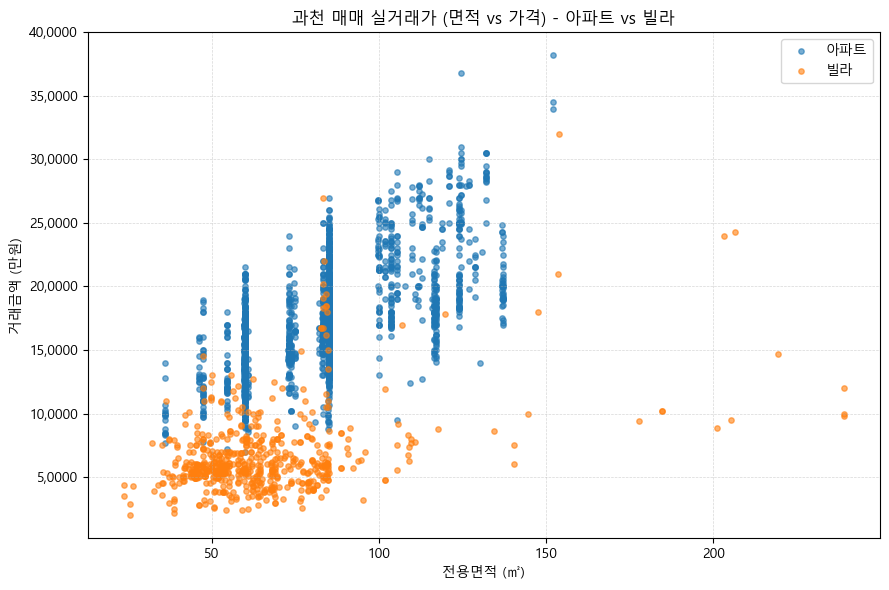

In [83]:
# 2) 컬럼 자동 매핑 (여러 이름 후보 중 존재하는 것을 선택)
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"가능한 컬럼을 찾지 못했습니다. 후보: {candidates}")

# ====== 파일 경로를 본인 환경에 맞게 수정하세요 ======
csv_path = r"C:\seocho\과천시_아파트_연립다세대_매매_실거래가_2021-2025_통합.csv"
# ================================================

df = read_csv_any_encoding(csv_path)

# 3) 구분 컬럼(아파트/연립다세대) 확인
type_col = pick_col(df, ["구분", "주택유형", "유형"])
# 연립다세대를 "빌라"로 표시
df["유형"] = df[type_col].replace({"연립다세대": "빌라"})

# 4) 면적/가격 컬럼 추정
area_col = pick_col(df, [
    "전용면적(㎡)", "전용면적", "면적(㎡)", "면적", "대지면적(㎡)", "대지면적"
])

price_col = pick_col(df, [
    "거래금액(만원)", "거래금액", "매매가격(만원)", "매매가격", "가격(만원)", "가격"
])

# 5) 숫자화(문자/쉼표/단위 제거)
def to_numeric_series(s):
    s = s.astype(str).str.replace(",", "", regex=False)
    # 숫자/소수점 외 문자 제거
    s = s.str.replace(r"[^0-9.]", "", regex=True)
    # 빈 문자열을 NaN으로
    s = s.replace({"": None})
    return pd.to_numeric(s, errors="coerce")

df["_면적"] = to_numeric_series(df[area_col])
df["_가격_만원"] = to_numeric_series(df[price_col])

# 6) 이상치/결측치 제거
plot_df = df.dropna(subset=["_면적", "_가격_만원"]).copy()
plot_df = plot_df[(plot_df["_면적"] > 0) & (plot_df["_가격_만원"] > 0)]

# 7) 아파트/빌라 분리
apt = plot_df[plot_df["유형"] == "아파트"]
villa = plot_df[plot_df["유형"] == "빌라"]

# 7-1) 👉 만 단위 콤마 포맷 함수 정의
def korean_ten_thousand_formatter(x, pos):
    value = int(x)
    s = str(value)
    parts = []
    while s:
        parts.insert(0, s[-4:])  # 끝에서 4자리씩 잘라서 앞으로 쌓음
        s = s[:-4]
    return ",".join(parts)

# 8) 산포도 그리기 (matplotlib, 서로 다른 색)
plt.figure(figsize=(9, 6))
plt.scatter(apt["_면적"], apt["_가격_만원"], s=15, alpha=0.6, label="아파트", color="tab:blue")
plt.scatter(villa["_면적"], villa["_가격_만원"], s=15, alpha=0.6, label="빌라", color="tab:orange")

plt.title("과천 매매 실거래가 (면적 vs 가격) - 아파트 vs 빌라")
plt.xlabel("전용면적 (㎡)")
plt.ylabel("거래금액 (만원)")

# 4) 👉 y축에 '만 단위 콤마' 적용
plt.gca().yaxis.set_major_formatter(FuncFormatter(korean_ten_thousand_formatter))

plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 2. 범주형 데이터의 분석 : 2개의 열 ###
- 표=교차표 : 빈도, 전체 백분율, 행 백분율, 열 백분율
- 데이터 시각화 : 누적막대그래프

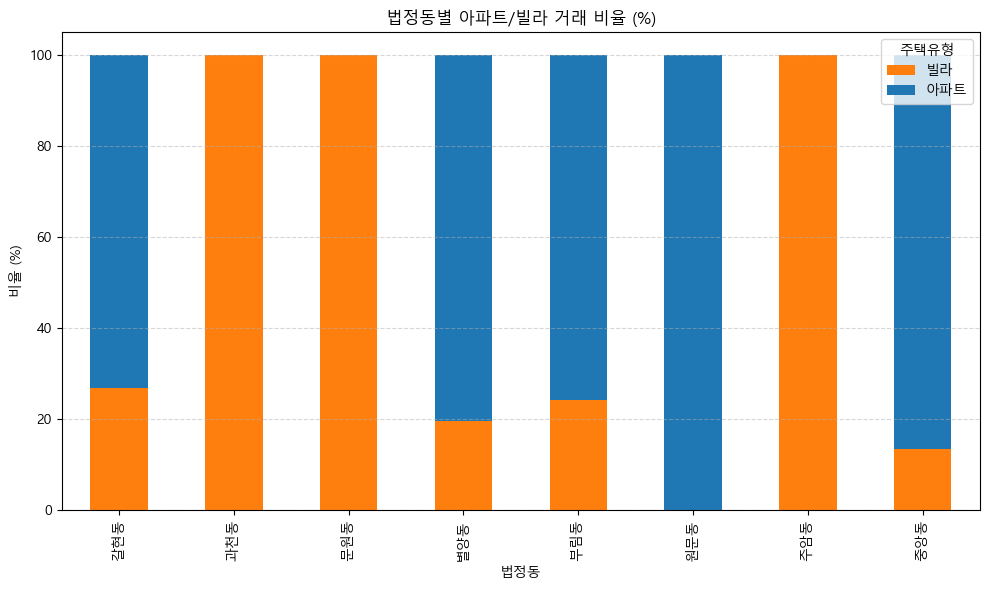

In [84]:
# ===== 데이터 전처리 =====
df["유형"] = df["구분"].replace({"연립다세대": "빌라"})

crosstab = pd.crosstab(df["법정동"], df["유형"])
crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# ===== 그래프 =====
ax = crosstab_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    color=["tab:orange", "tab:blue"]
)

plt.title("법정동별 아파트/빌라 거래 비율 (%)")
plt.xlabel("법정동")
plt.ylabel("비율 (%)")
plt.legend(title="주택유형", loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 시계열 분석 ##
- 최근 5개년간 거래량
- 최근 5개년간 중위값 변동현황

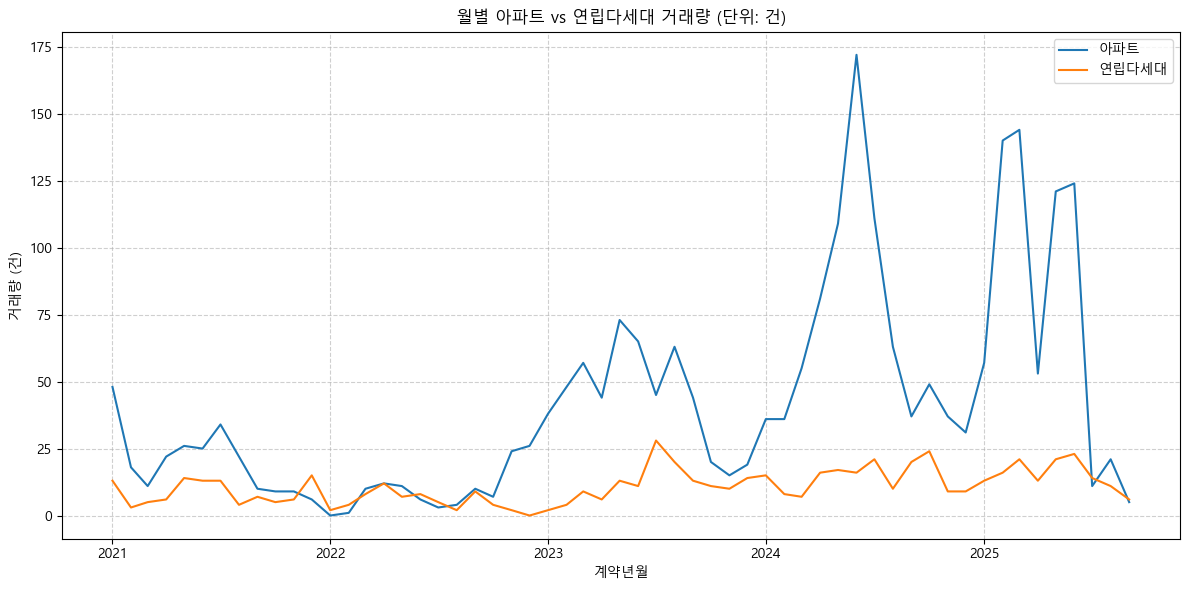

In [85]:
# 계약년월 컬럼 확인 및 변환
df["계약년월"] = pd.to_datetime(df["계약년월"].astype(str), format="%Y%m")

# 월별 건수 집계
monthly_counts = df.groupby([df["계약년월"], df["구분"]]).size().unstack(fill_value=0)

# 그래프
plt.figure(figsize=(12,6))
plt.plot(monthly_counts.index, monthly_counts.get("아파트", 0),
         label="아파트", color="tab:blue")
plt.plot(monthly_counts.index, monthly_counts.get("연립다세대", 0),
         label="연립다세대", color="tab:orange")

plt.title("월별 아파트 vs 연립다세대 거래량 (단위: 건)")
plt.xlabel("계약년월")
plt.ylabel("거래량 (건)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


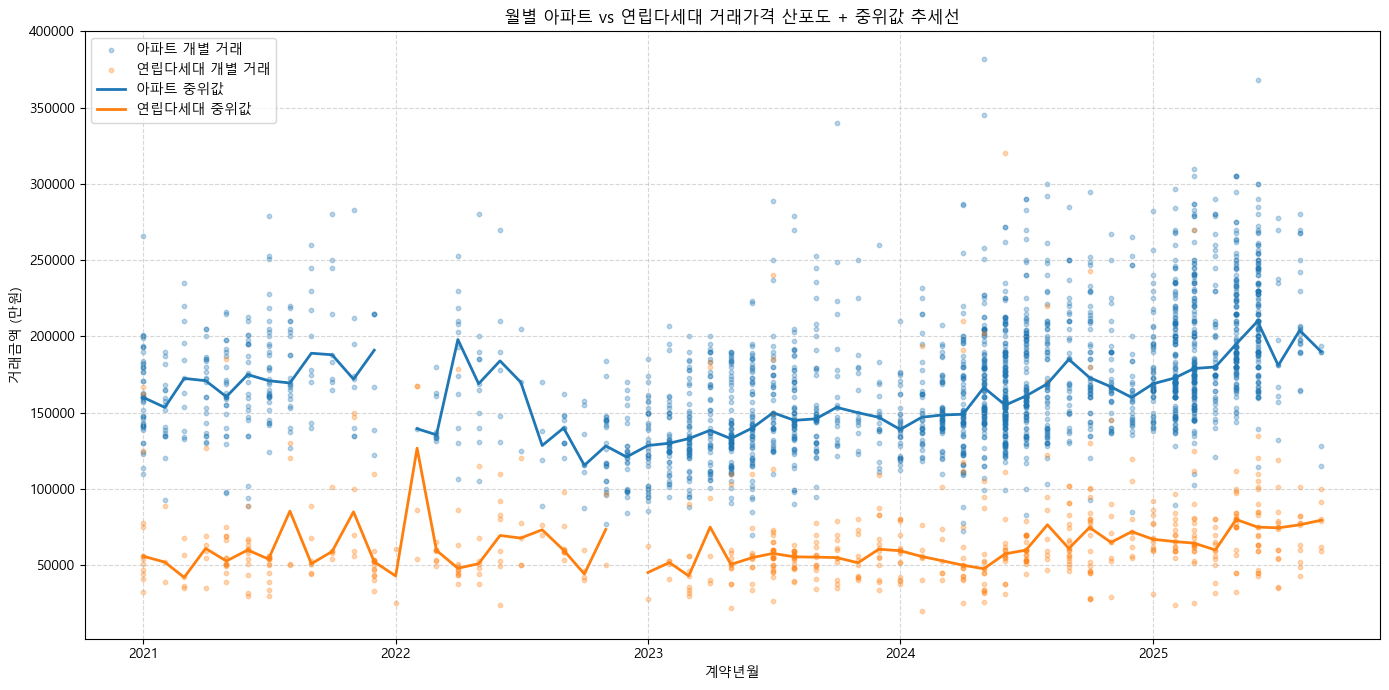

In [86]:
# 계약년월 컬럼 문자열 변환
df["계약년월"] = df["계약년월"].astype(str).str.strip()

# 길이에 따라 포맷 분리 처리
def parse_date(val):
    if len(val) == 6:     # "202112"
        return pd.to_datetime(val, format="%Y%m", errors="coerce")
    else:                 # "2021-12-01" 같은 ISO 형식
        return pd.to_datetime(val, errors="coerce")

df["계약년월"] = df["계약년월"].apply(parse_date)

# 거래금액 숫자화
df["_거래금액"] = (
    df["거래금액(만원)"].astype(str)
    .str.replace(",", "", regex=False)
    .str.replace(r"[^0-9]", "", regex=True)
)
df["_거래금액"] = pd.to_numeric(df["_거래금액"], errors="coerce")

# 산포도
plt.figure(figsize=(14,7))
plt.scatter(df.loc[df["구분"]=="아파트", "계약년월"],
            df.loc[df["구분"]=="아파트", "_거래금액"],
            s=10, alpha=0.3, color="tab:blue", label="아파트 개별 거래")
plt.scatter(df.loc[df["구분"]=="연립다세대", "계약년월"],
            df.loc[df["구분"]=="연립다세대", "_거래금액"],
            s=10, alpha=0.3, color="tab:orange", label="연립다세대 개별 거래")

# 월별 중위값 계산
median_price = df.groupby(["계약년월", "구분"])["_거래금액"].median().unstack()

# 중위값 선 추가
plt.plot(median_price.index, median_price["아파트"], color="tab:blue",
         linewidth=2, label="아파트 중위값")
plt.plot(median_price.index, median_price["연립다세대"], color="tab:orange",
         linewidth=2, label="연립다세대 중위값")

plt.title("월별 아파트 vs 연립다세대 거래가격 산포도 + 중위값 추세선")
plt.xlabel("계약년월")
plt.ylabel("거래금액 (만원)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()